# Insurance Customer Data

This notebook analyses the Insurance Customer Data dataset

- https://www.kaggle.com/datasets/chetan0361/insurance-customer-data?select=customer_training_dataset.csv

### Steps:
- Step 1: Load Data
- Step 2: First 5 rows
- Step 3: Plot Data
- Step 4: Prepare for Modelling
- Step 5: Modeling

### Models

xx

### Results

xx

# Step 0: Imports

In [2]:
#============================================
# Imports

#--------------------
# General
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.2f}'.format
#--------------------

#--------------------
# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt
#--------------------

#--------------------
# Models
# XGBoost
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier
#--------------------

#--------------------
# SHAP Explainability
import shap
shap.initjs()
#--------------------

#--------------------
# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#--------------------

#--------------------
# Gini by split
def gini_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate Gini for each group
    """
    levels=group.unique()
    values=[]
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        values.append(roc_auc_score(y_true=this_y_true, y_score=this_y_score)*2-1)
    return pd.DataFrame({'group':levels, 'Gini':values}).round(round)
#--------------------

#--------------------
# ROC Curve
def roc_curve_group(y_true=None, y_score=None, group=None, round=2):
    """
    Calculate ROC Curve for each group
    """
    levels=group.unique()
    prep_auc=pd.DataFrame()
    for this_level in levels:
        this_y_true=y_true[group==this_level]
        this_y_score=y_score[group==this_level]
        fpr, tpr, _= roc_curve(y_true=this_y_true, y_score=this_y_score)
        t1=pd.DataFrame({'Model': this_level, 'fpr': fpr, 'tpr': tpr})
        prep_auc=pd.concat([prep_auc, t1], axis=0)
    return prep_auc.round(round)
#--------------------
#============================================

# Step 1: Load Data

In [10]:
#============================================
# Load Data
#df=pd.read_csv('customer_training_dataset.csv')

loc='C:/Users/markt/My Drive/99 ML/17 Kaggle/04 Insurance Customer Data/'
df=pd.read_parquet(f"{loc}customer_training_dataset.parquet").drop(columns='Unnamed: 0')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [6]:
df.to_parquet("customer_training_dataset.parquet", index=False)

# Step 2: First 5 rows

In [107]:
#============================================
# First 5 rows
print('--------------------')
print('## First 5 rows ##')
print(df.head(5))
print('--------------------')
#============================================

--------------------
## First 5 rows ##
                status  duration  credit_history     purpose  amount  \
0  no_checking_account        18  paid this bank   car_used_    1049   
1  no_checking_account         9  paid this bank      others    2799   
2            _-inf_ 0_        12      no credits  retraining     841   
3  no_checking_account        12  paid this bank      others    2122   
4  no_checking_account        12  paid this bank      others    2171   

              savings employment_duration installment_rate  \
0  unknown/no_account               _0_1_        _-inf_20_   
1  unknown/no_account               _1_4_          _25_35_   
2          _-inf_100_               _4_7_          _25_35_   
3  unknown/no_account               _1_4_          _20_25_   
4  unknown/no_account               _1_4_        _-inf_20_   

             personal_status_sex other_debtors present_residence  \
0  femalenonsingle_or_malesingle          none           _7_inf_   
1            male_

# Step 3: Plot Data

### Response ['bad_flag']

There are 1000 examples, 700 goods and 300 bads.

### Numerical Features 

['duration', 'amount', 'age']

### Categorical Featues 

['status', 'credit_history', 'purpose', 'savings', 
       'employment_duration',
       'installment_rate', 'personal_status_sex', 'other_debtors',
       'present_residence', 'property', 'other_installment_plans', 'housing',
       'number_credits', 'job', 'people_liable', 'telephone',
       'foreign_worker']

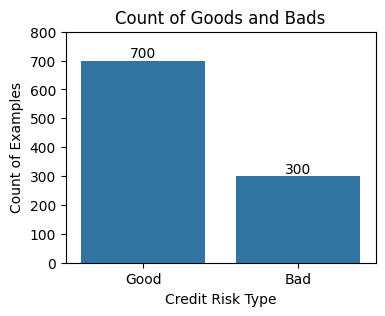

In [108]:
#============================================
# Plot Response

# Summarise for the plot
df_smry=df['bad_flag'].value_counts().reset_index()
df_smry['bad_flag']=df_smry['bad_flag'].map({0:'Good', 1:'Bad'})

# Response plot
plt.figure(figsize=(4,3))
ax=sns.barplot(df_smry, x='bad_flag', y='count')
ax.bar_label(ax.containers[0])
ax.set_xlabel('Credit Risk Type')
ax.set_ylabel('Count of Examples')
plt.ylim(0, 800) 
plt.title('Count of Goods and Bads')
plt.show()
#============================================

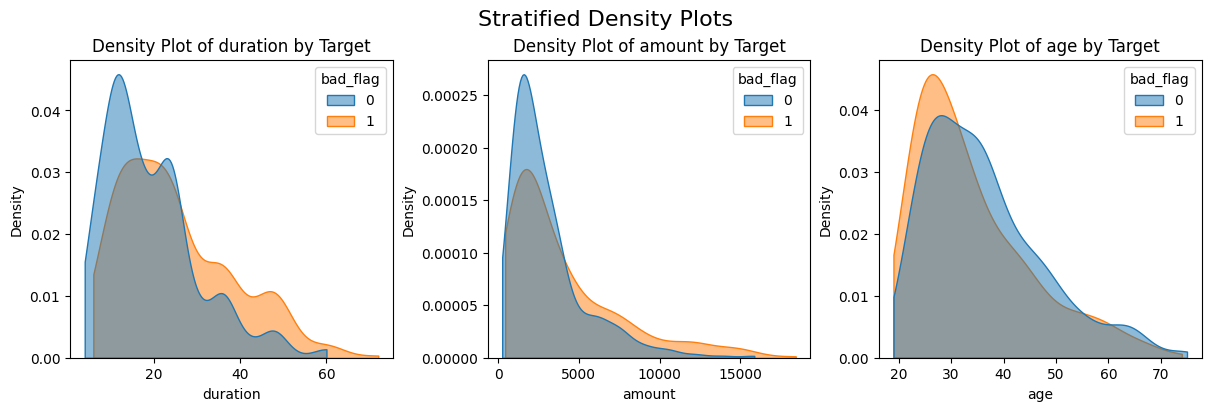

In [109]:
#============================================
# Plot Numeric Features

# Numeric Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('bad_flag')
num_numeric_cols=len(numeric_cols)

# KDE Plots
fig, axes = plt.subplots(1, num_numeric_cols, figsize=(12, 4), constrained_layout=True)
for i, this_var in enumerate(numeric_cols):
    sns.kdeplot(data=df, 
                x=this_var, 
                hue='bad_flag', 
                fill=True, 
                common_norm=False,
                cut=0,
                alpha=0.5,
                ax=axes[i])
    axes[i].set_title(f'Density Plot of {this_var} by Target', fontsize=12)
fig.suptitle('Stratified Density Plots', fontsize=16)
plt.show()
#============================================

# Insights from Stratified KDE Plots

The stratified KDE (Kernel Density Estimate) plots provide insights into the distribution of numerical features(`duration`, `amount`, `age`) stratified by the target variable (`bad_flag`). Here are the key observations:

## 1. Duration
- The distribution of `duration` for both good and bad credit risks shows that longer durations are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at higher durations, indicating that longer loan durations might be associated with higher credit risk.

## 2. Amount
- The distribution of `amount` for both good and bad credit risks shows that higher loan amounts are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at higher loan amounts, suggesting that larger loan amounts might be associated with higher credit risk.

## 3. Age
- The distribution of `age` for both good and bad credit risks shows that younger individuals are more common among bad credit risks.
- There is a noticeable peak for bad credit risks at lower ages, indicating that younger age might be associated with higher credit risk.

---

Overall, the stratified KDE plots suggest that longer loan durations, higher loan amounts, and younger ages are associated with higher credit risk. These insights can be useful for understanding the characteristics of high-risk loans and individuals.


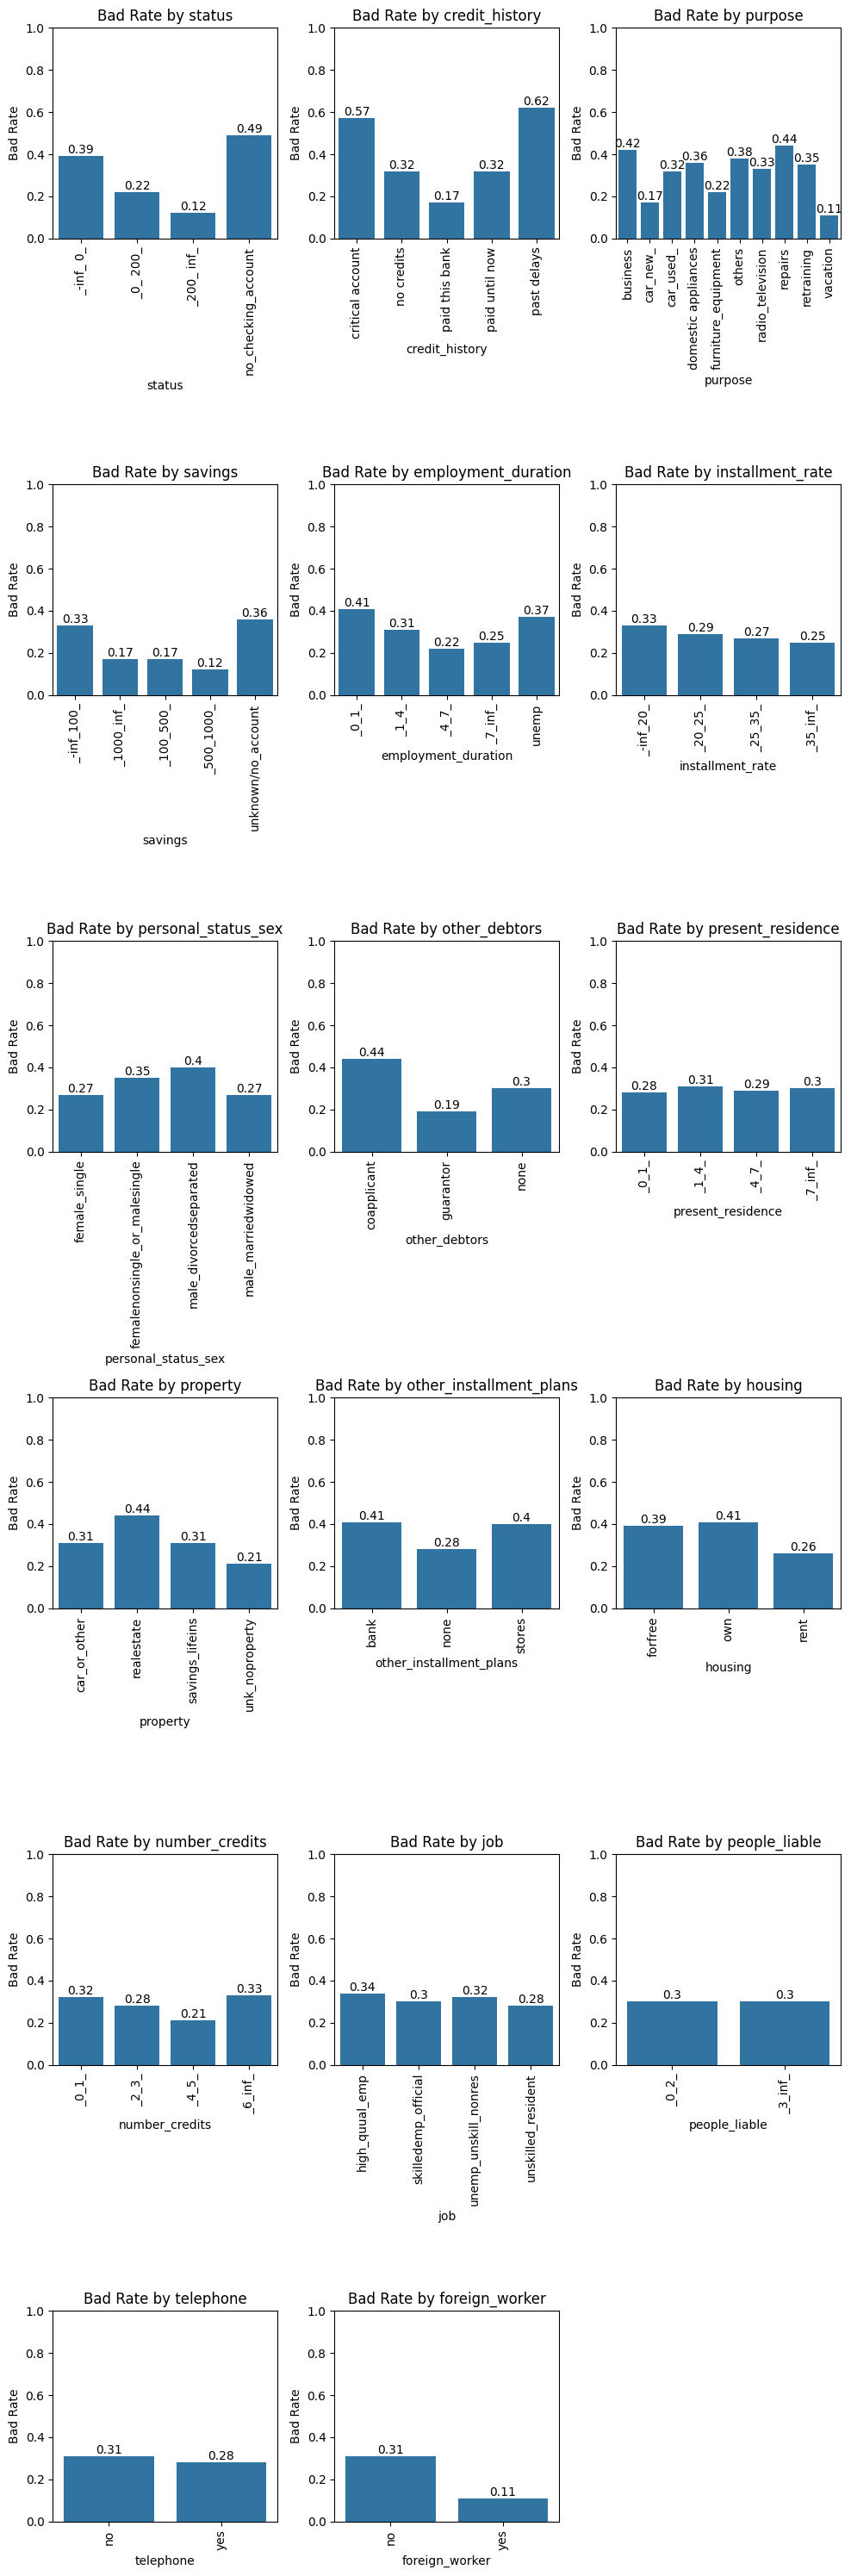

In [110]:
#============================================
# Plot Categorical Features

# Identify categorical columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
num_categorical_cols = len(categorical_cols)

# Set up grid dimensions
cols = 3
rows = (num_categorical_cols + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over categorical columns
for i, col in enumerate(categorical_cols):
    df_smry = df[['bad_flag', col]].groupby(col).mean().reset_index().round(2)

    ax = axes[i]  # Get the current axis
    sns.barplot(data=df_smry, x=col, y='bad_flag', ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_xlabel(col)
    ax.set_ylabel('Bad Rate')
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(0, 1)
    ax.set_title(f'Bad Rate by {col}')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
#============================================

# Step 4: Prepare for Modelling

Undertake the following:

- one-hot dummy encoding of categorical featuers
- train-test split

In [111]:
# One-Hot Encoding
df2=copy.deepcopy(pd.get_dummies(df,dtype=int))
df2.columns=df2.columns.str.replace('-', '_').str.replace(' ', '_')

# X and y
X=df2.drop(['bad_flag'], axis=1)
y=df2['bad_flag']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Modeling

- XGBoost
- LightGBM
- CatBoost
- Random Forest
- Logistic Regression
- Naive Bayes
- K-Nearest Neighbours
- Support Vector Machine
- Neural Network (Multilayer Perceptron)
- Linear Discriminant Analysis

In [112]:
#--------------------
# XGBoost
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
pred_xgb=pd.DataFrame({'model': 'xgb', 'target': y_test, 'pred': model_xgb.predict_proba(X_test)[:,1]})
#--------------------

In [113]:
#--------------------
# Light GBM
model_lgb=LGBMClassifier(verbose=-1)
model_lgb.fit(X_train, y_train)
pred_lgb=pd.DataFrame({'model': 'lgb', 'target': y_test, 'pred': model_lgb.predict_proba(X_test)[:,1]})
#--------------------

In [114]:
#--------------------
# Catboost
model_cat=CatBoostClassifier(verbose=False)
model_cat.fit(X_train, y_train)
pred_cat=pd.DataFrame({'model': 'cat', 'target': y_test, 'pred': model_cat.predict_proba(X_test)[:,1]})
#--------------------

In [115]:
#--------------------
# Random Forrest
model_rfc=RandomForestClassifier()
model_rfc.fit(X_train, y_train)
pred_rfc=pd.DataFrame({'model': 'rf', 'target': y_test, 'pred': model_rfc.predict_proba(X_test)[:,1]})
#--------------------

In [116]:
#--------------------
# Logistic Regression
model_lrg=LogisticRegression(penalty=None, solver='newton-cg')
model_lrg.fit(X_train, y_train)
pred_lrg=pd.DataFrame({'model': 'lr', 'target': y_test, 'pred': model_lrg.predict_proba(X_test)[:,1]})
#--------------------

In [117]:
#--------------------
# Naive Bayes
model_nb=GaussianNB()
model_nb.fit(X_train,  y_train)
pred_nb=pd.DataFrame({'model': 'nb', 'target': y_test, 'pred': model_nb.predict_proba(X_test)[:,1]})
#--------------------

In [118]:
#--------------------
# K-Nearest Neighbours
model_knn=KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_knn=pd.DataFrame({'model': 'knn', 'target': y_test, 'pred': model_knn.predict_proba(X_test)[:,1]})
#--------------------

In [119]:
#--------------------
# Support Vector Machine
model_svc=SVC(probability=True)
model_svc.fit(X_train, y_train)
pred_svc=pd.DataFrame({'model': 'svc', 'target': y_test, 'pred': model_svc.predict_proba(X_test)[:,1]})
#--------------------

In [120]:
#--------------------
# Neural Network - Multilayer Perception
model_mlp=MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000)
model_mlp.fit(X_train, y_train)
pred_mlp=pd.DataFrame({'model': 'nn', 'target': y_test, 'pred': model_mlp.predict_proba(X_test)[:,1]})
#--------------------

In [121]:
#--------------------
# Linear Discriminant Analysis
model_lda=LinearDiscriminantAnalysis()
model_lda.fit(X_train, y_train)
pred_lda=pd.DataFrame({'model': 'lda', 'target': y_test, 'pred': model_lda.predict_proba(X_test)[:,1]})
#--------------------

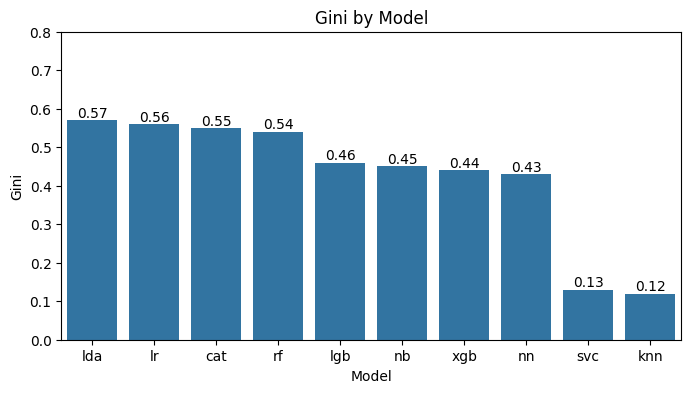

In [122]:
# Join all predictions
pred=pd.concat([pred_xgb, 
                pred_lgb, 
                pred_cat, 
                pred_rfc, 
                pred_lrg, 
                pred_nb, 
                pred_knn, 
                pred_svc, 
                pred_mlp, 
                pred_lda], axis=0).reset_index(drop=True)

# Gini
gini_df=gini_group(y_true=pred['target'], 
                   y_score=pred['pred'], 
                   group=pred['model'], 
                   round=2)\
                  .sort_values('Gini', ascending=False)\
                  .reset_index()

# ROC Curve
plt.figure(figsize=(8, 4))
ax=sns.barplot(data=gini_df, y='Gini', x='group')
ax.bar_label(ax.containers[0])
plt.ylabel('Gini')
plt.xlabel('Model')
plt.ylim(0, 0.8)
plt.title('Gini by Model')
plt.show()

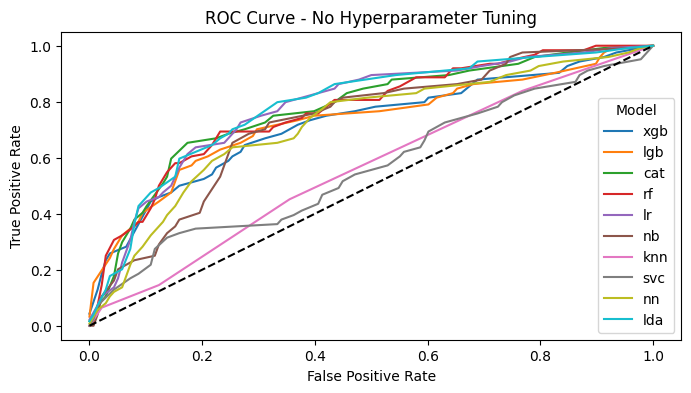

In [123]:
# ROC Curve
roc_curve_df=roc_curve_group(y_true=pred['target'], 
                             y_score=pred['pred'], 
                             group=pred['model'], 
                             round=6)

# Plot ROC Curve
plt.figure(figsize=(8, 4))
sns.lineplot(data=roc_curve_df, x='fpr', y='tpr', hue='Model', errorbar=None)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - No Hyperparameter Tuning')
plt.show()